In [2]:
%load_ext autoreload
%autoreload 2
%cd ../

/mainfs/home/jd5u19/progressive-tradeoff/main


In [3]:

import numpy as np
from utils.analysis_utils import get_distribution,get_distribution_with_exits,get_OOD_usage,get_optimum_policy

import matplotlib.pyplot as plt
height = 8
width = height*1.6
plt.rcParams["figure.figsize"] = (width,height)
plt.style.use('seaborn-colorblind')

# import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

height = 8
width = height*1.6
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["figure.figsize"] = (width,height)
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['xtick.major.width'] = 1.6
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = "black"
plt.rcParams['axes.linewidth'] = 1.6
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.size'] = 25

In [4]:
    
def plot_macs_vs_acc(directory,exit_policy='entropic', exits_provided = False, label_note = '', decision_module_path = None, colour=False, label=True):

    name = directory.split('/')[3] + ' -- ' + directory.split('/')[4]
    # name = directory.split('/')[4]
    name = name.replace('_',' ') + label_note

    # name = directory.split('/')[4].split('d')[-1] + ' layer'

    outputs = np.load(directory+'/outputs.npy')
    labels = np.load(directory+'/labels.npy')
    powers = np.load(directory+'/power_usage.npy')
    if exits_provided == True:
        if exit_policy == 'entropic':
            exit_probs = 1-np.load(directory+'/exits/entropic.npy')
        elif exit_policy == 'decision_module':
            assert decision_module_path, 'please specify which decision module to examine'
            exit_probs = np.load(directory+'/exits/decision_modules/'+decision_module_path+'.npy')
        else:
            print('Invalid exit policy selected: Using entropic')
            exit_probs = 1-np.load(directory+'/exits/entropic.npy')

        accs,macs,exit_p = get_distribution_with_exits(outputs,labels,powers,exit_probs,n_thresh=25)
    else:
        accs,macs,exit_p = get_distribution(outputs,labels,powers,policy=exit_policy)

    mean_accs = accs[:,0]
    std_accs = accs[:,1]

    if label and colour:
        plt.plot(macs,mean_accs,label=name,color=colour)
        plt.fill_between(macs,mean_accs+std_accs,mean_accs-std_accs,alpha=0.2,color=colour)
    elif label and not colour:
        plt.plot(macs,mean_accs,label=name)
        plt.fill_between(macs,mean_accs+std_accs,mean_accs-std_accs,alpha=0.2)
    elif colour and not label:
        plt.plot(macs,mean_accs,color=colour)
        plt.fill_between(macs,mean_accs+std_accs,mean_accs-std_accs,alpha=0.2,color=colour)
    else:
        plt.plot(macs,mean_accs)
        plt.fill_between(macs,mean_accs+std_accs,mean_accs-std_accs,alpha=0.2)
        
    if exits_provided == True:
        return exit_probs
    
def plot_OOD_mixed_performance(directory,exit_policy='entropic', OOD_set = 'CIFAR100', exits_provided = False, label_note = '', decision_module_path = None, colour=False, label=True):

    name = directory.split('/')[3] + ' -- ' + directory.split('/')[4]
    # name = directory.split('/')[4]
    name = name.replace('_',' ') + label_note

    # name = directory.split('/')[4].split('d')[-1] + ' layer'

    outputs = np.load(directory+'/outputs.npy')
    labels = np.load(directory+'/labels.npy')
    powers = np.load(directory+'/power_usage.npy')
    OOD_entropies = np.load(directory+'../OOD_analysis/'+OOD_set+'/entropies.npy')

    if exits_provided == True:
        if exit_policy == 'entropic':
            exit_probs = 1-np.load(directory+'/exits/entropic.npy')
        elif exit_policy == 'decision_module':
            assert decision_module_path, 'please specify which decision module to examine'
            exit_probs = np.load(directory+'/exits/decision_modules/'+decision_module_path+'.npy')
        else:
            print('Invalid exit policy selected: Using entropic')
            exit_probs = 1-np.load(directory+'/exits/entropic.npy')

        accs,macs,exit_p = get_distribution_with_exits(outputs,labels,powers,exit_probs,n_thresh=25)
    else:
        accs,macs,exit_p = get_distribution(outputs,labels,powers,policy=exit_policy)
        
    mean_accs = accs[:,0]
    std_accs = accs[:,1]

    OOD_branch_usage = get_OOD_usage(OOD_entropies,n_thresh=25)
    
    for threshold_idx in range(OOD_branch_usage.shape[0]):
        weighted_usage = np.dot(OOD_branch_usage[threshold_idx],exit_p[threshold_idx])
        mean_accs[threshold_idx] = (mean_accs[threshold_idx]+weighted_usage)/2

    if label and colour:
        plt.plot(macs,mean_accs,label=name,color=colour)
        plt.fill_between(macs,mean_accs+std_accs,mean_accs-std_accs,alpha=0.2,color=colour)
    elif label and not colour:
        plt.plot(macs,mean_accs,label=name)
        plt.fill_between(macs,mean_accs+std_accs,mean_accs-std_accs,alpha=0.2)
    elif colour and not label:
        plt.plot(macs,mean_accs,color=colour)
        plt.fill_between(macs,mean_accs+std_accs,mean_accs-std_accs,alpha=0.2,color=colour)
    else:
        plt.plot(macs,mean_accs)
        plt.fill_between(macs,mean_accs+std_accs,mean_accs-std_accs,alpha=0.2)
        
    if exits_provided == True:
        return exit_probs
    
def plot_OOD_performance(directory,exit_policy='entropic', OOD_set = 'CIFAR100', exits_provided = False, label_note = '', decision_module_path = None, colour=False, label=True):

    name = directory.split('/')[3] + ' -- ' + directory.split('/')[4]
    # name = directory.split('/')[4]
    name = name.replace('_',' ') + label_note

    # name = directory.split('/')[4].split('d')[-1] + ' layer'

    outputs = np.load(directory+'/outputs.npy')
    labels = np.load(directory+'/labels.npy')
    powers = np.load(directory+'/power_usage.npy')
    OOD_entropies = np.load(directory+'../OOD_analysis/'+OOD_set+'/entropies.npy')

    if exits_provided == True:
        if exit_policy == 'entropic':
            exit_probs = 1-np.load(directory+'/exits/entropic.npy')
        elif exit_policy == 'decision_module':
            assert decision_module_path, 'please specify which decision module to examine'
            exit_probs = np.load(directory+'/exits/decision_modules/'+decision_module_path+'.npy')
        else:
            print('Invalid exit policy selected: Using entropic')
            exit_probs = 1-np.load(directory+'/exits/entropic.npy')

        accs,macs,exit_p = get_distribution_with_exits(outputs,labels,powers,exit_probs,n_thresh=25)
    else:
        accs,macs,exit_p = get_distribution(outputs,labels,powers,policy=exit_policy)
        
    mean_accs = accs[:,0]
    std_accs = accs[:,1]

    OOD_branch_usage = get_OOD_usage(OOD_entropies,n_thresh=25)
    
    for threshold_idx in range(OOD_branch_usage.shape[0]):
        weighted_usage = np.dot(OOD_branch_usage[threshold_idx],exit_p[threshold_idx])
        mean_accs[threshold_idx] = weighted_usage

    if label and colour:
        plt.plot(macs,mean_accs,label=name,color=colour)
        plt.fill_between(macs,mean_accs+std_accs,mean_accs-std_accs,alpha=0.2,color=colour)
    elif label and not colour:
        plt.plot(macs,mean_accs,label=name)
        plt.fill_between(macs,mean_accs+std_accs,mean_accs-std_accs,alpha=0.2)
    elif colour and not label:
        plt.plot(macs,mean_accs,color=colour)
        plt.fill_between(macs,mean_accs+std_accs,mean_accs-std_accs,alpha=0.2,color=colour)
    else:
        plt.plot(macs,mean_accs)
        plt.fill_between(macs,mean_accs+std_accs,mean_accs-std_accs,alpha=0.2)
        
    if exits_provided == True:
        return exit_probs

(10000, 4)
(10000, 4)
(10000,)
[1.53550848e+08 2.88195850e+08 4.22629140e+08 5.57024680e+08]
(10000, 4)


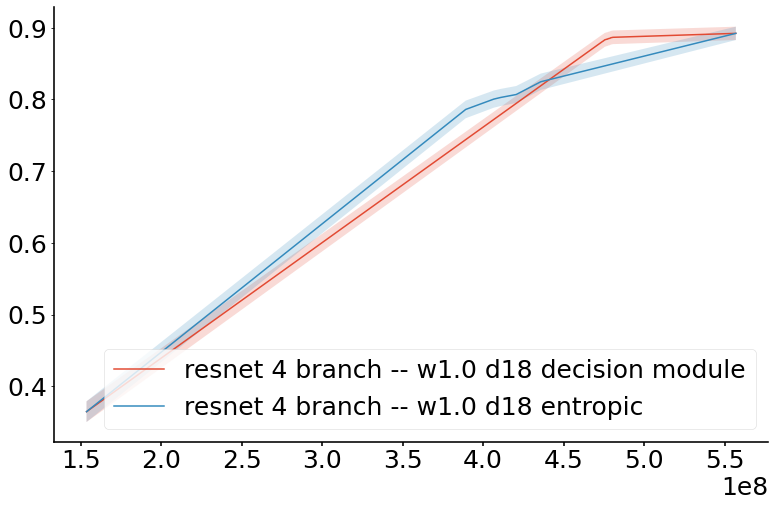

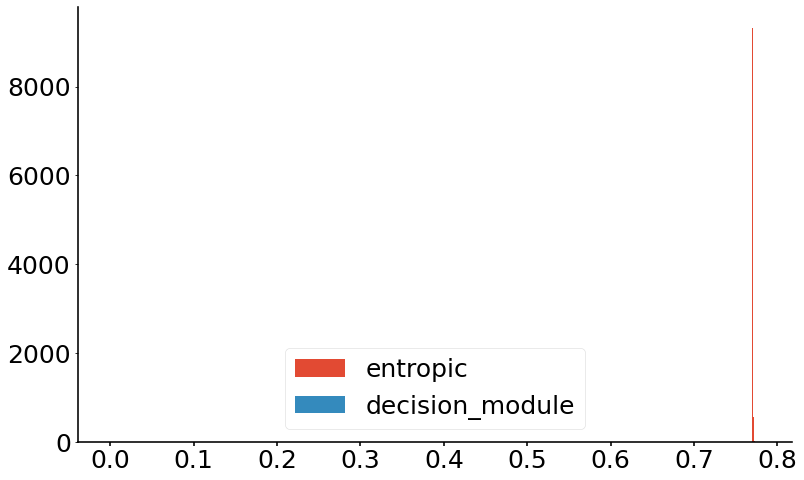

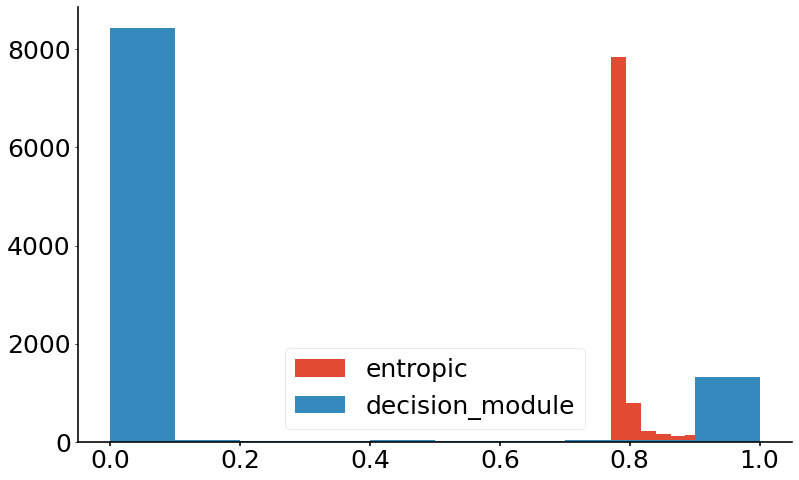

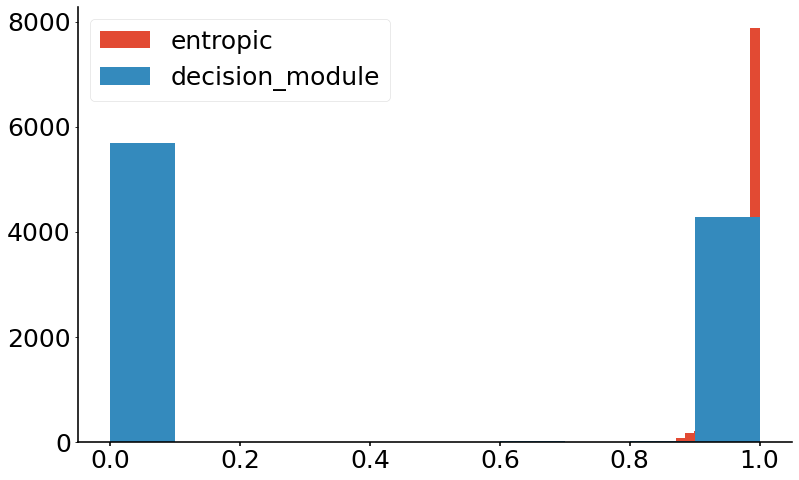

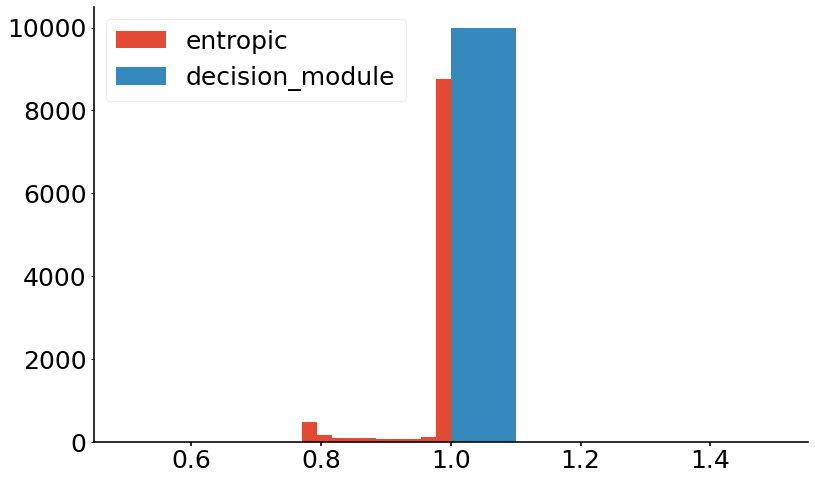

In [5]:
dir = '../trained-models/CIFAR10/resnet_4_branch/w1.0_d18/300-epoch/analysis/'
dir = '../trained-models/CIFAR10/resnet_4_branch/w1.0_d18/resolution-dependant-lr005-dirichlet-loss/analysis/'
decision_module_exits = plot_macs_vs_acc(dir,exit_policy='decision_module',exits_provided = True,decision_module_path = 'linear_heavy_accuracy_weighted_loss',label_note=' decision module')
entropic_exits = plot_macs_vs_acc(dir,exit_policy='entropic',exits_provided = True,label_note=' entropic')
optimum_exits,correct,powers = get_optimum_policy(dir)

print(powers)
total_power=(optimum_exits*powers)
print(total_power.shape)

plt.legend(loc=4)
# plt.xscale('log')
plt.show()

for branch in range(4):
    plt.hist(entropic_exits[:,branch],label='entropic')
    plt.hist(decision_module_exits[:,branch],label='decision_module')
    plt.legend()
    plt.show()

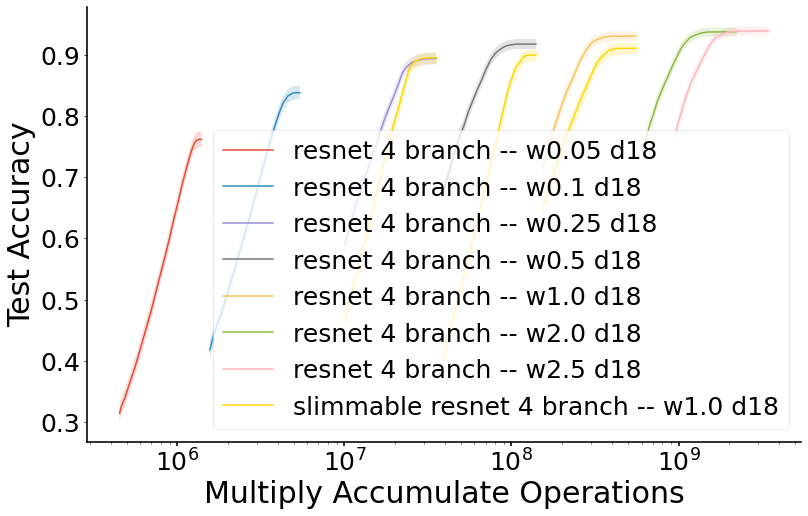

In [6]:
plot_macs_vs_acc('../trained-models/CIFAR10/resnet_4_branch/w0.05_d18/300-epoch/analysis/')
plot_macs_vs_acc('../trained-models/CIFAR10/resnet_4_branch/w0.1_d18/300-epoch/analysis/')
plot_macs_vs_acc('../trained-models/CIFAR10/resnet_4_branch/w0.25_d18/300-epoch/analysis/')
plot_macs_vs_acc('../trained-models/CIFAR10/resnet_4_branch/w0.5_d18/300-epoch/analysis/')
plot_macs_vs_acc('../trained-models/CIFAR10/resnet_4_branch/w1.0_d18/300-epoch/analysis/')
plot_macs_vs_acc('../trained-models/CIFAR10/resnet_4_branch/w2.0_d18/300-epoch/analysis/')
plot_macs_vs_acc('../trained-models/CIFAR10/resnet_4_branch/w2.5_d18/300-epoch/analysis/')

plot_macs_vs_acc('../trained-models/CIFAR10/slimmable_resnet_4_branch/w1.0_d18/out_in_out_finetune/analysis/quarter/',colour='gold',label=True)
plot_macs_vs_acc('../trained-models/CIFAR10/slimmable_resnet_4_branch/w1.0_d18/out_in_out_finetune/analysis/half/',label_note=' half ',colour='gold',label=False)
plot_macs_vs_acc('../trained-models/CIFAR10/slimmable_resnet_4_branch/w1.0_d18/out_in_out_finetune/analysis/full/',label_note=' full ',colour='gold',label=False)


powers = [556905482.0,139230218.0,34811402.0,15003146.0,11626250.0]

# plt.vlines([556905482.0,139230218.0,34811402.0,15003146.0,11626250.0],0.05,0.95,colors='lightgrey',alpha=0.9)


plt.legend()
plt.xscale('log')
# plt.grid(color='grey', linestyle='-', linewidth=0.3)
# plt.grid(which='minor',color='lightgrey', linestyle='--', linewidth=0.3)
plt.ylabel('Test Accuracy')
plt.xlabel('Multiply Accumulate Operations')
plt.savefig('varied-width.pdf')
plt.show()


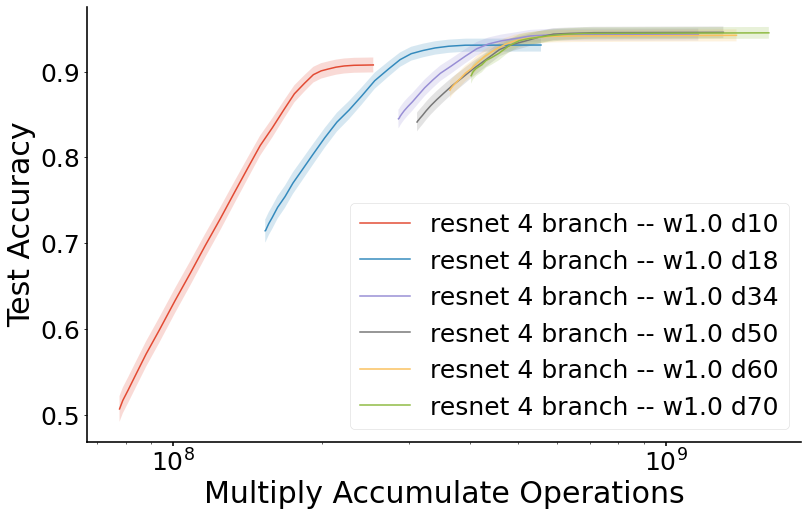

In [7]:
plot_macs_vs_acc('../trained-models/CIFAR10/resnet_4_branch/w1.0_d10/300-epoch/analysis/')
plot_macs_vs_acc('../trained-models/CIFAR10/resnet_4_branch/w1.0_d18/300-epoch/analysis/')
plot_macs_vs_acc('../trained-models/CIFAR10/resnet_4_branch/w1.0_d34/300-epoch/analysis/')
plot_macs_vs_acc('../trained-models/CIFAR10/resnet_4_branch/w1.0_d50/300-epoch/analysis/')
plot_macs_vs_acc('../trained-models/CIFAR10/resnet_4_branch/w1.0_d60/300-epoch/analysis/')
plot_macs_vs_acc('../trained-models/CIFAR10/resnet_4_branch/w1.0_d70/300-epoch/analysis/')

plt.legend()
plt.xscale('log')
plt.ylabel('Test Accuracy')
plt.xlabel('Multiply Accumulate Operations')
plt.savefig('varied-depth.pdf')
plt.show()


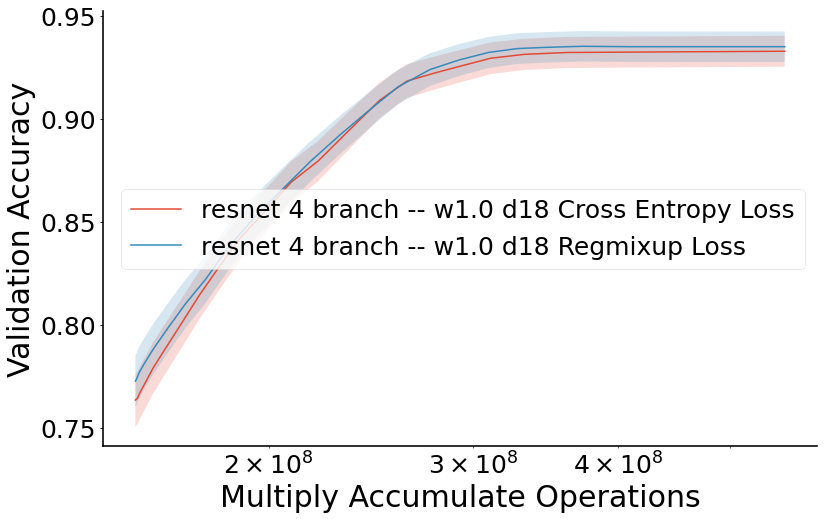

In [16]:
plot_macs_vs_acc('../trained-models/CIFAR10/resnet_4_branch/w1.0_d18/001-cross-entropy/analysis/',label_note=' Cross Entropy Loss')
# plot_macs_vs_acc('../trained-models/CIFAR10/resnet_4_branch/w1.0_d18/KL-decrease-lr005-dirichlet-loss/analysis/',label_note=' Dirichlet Loss')
# plot_macs_vs_acc('../trained-models/CIFAR10/resnet_4_branch/w1.0_d18/01-regmixup-regmixup-loss/analysis/',label_note=' Regmixup Loss lr 0.1')
# plot_macs_vs_acc('../trained-models/CIFAR10/resnet_4_branch/w1.0_d18/005-regmixup-regmixup-loss/analysis/',label_note=' Regmixup Loss lr 0.05')
plot_macs_vs_acc('../trained-models/CIFAR10/resnet_4_branch/w1.0_d18/005-regmixup-regmixup-loss/analysis/',label_note=' Regmixup Loss')

plt.legend()
plt.xscale('log')
plt.ylabel('Validation Accuracy')
plt.xlabel('Multiply Accumulate Operations')
# plt.ylim(0,1)
plt.show()

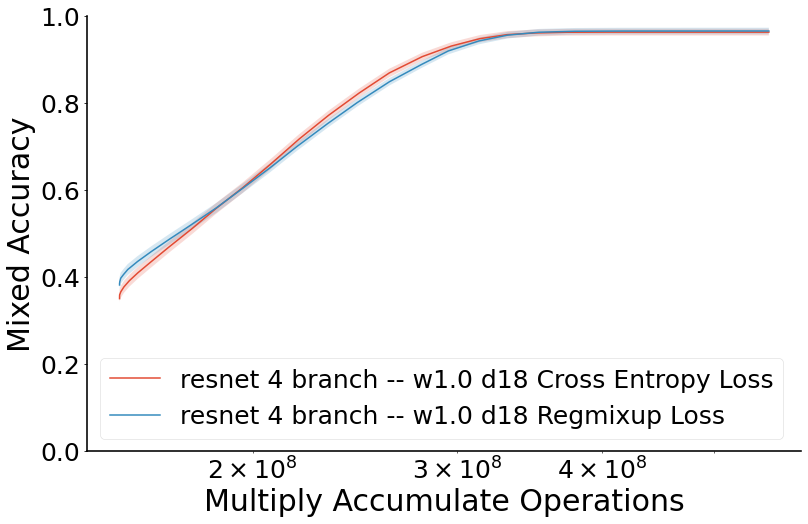

In [9]:
plot_OOD_mixed_performance('../trained-models/CIFAR10/resnet_4_branch/w1.0_d18/300-epoch-val-set/analysis/',label_note=' Cross Entropy Loss')
# plot_OOD_mixed_performance('../trained-models/CIFAR10/resnet_4_branch/w1.0_d18/KL-decrease-lr005-dirichlet-loss/analysis/',label_note=' Dirichlet Loss')
plot_OOD_mixed_performance('../trained-models/CIFAR10/resnet_4_branch/w1.0_d18/01-regmixup-regmixup-loss/analysis/',label_note=' Regmixup Loss')

plt.legend()
plt.xscale('log')
plt.ylabel('Mixed Accuracy')
plt.xlabel('Multiply Accumulate Operations')
plt.ylim(0,1)
plt.show()


/mainfs/home/jd5u19/progressive-tradeoff/main/utils/analysis_utils.py:8: RuntimeWarning: divide by zero encountered in log
  log = prediction*np.log(prediction)
/mainfs/home/jd5u19/progressive-tradeoff/main/utils/analysis_utils.py:8: RuntimeWarning: invalid value encountered in multiply
  log = prediction*np.log(prediction)


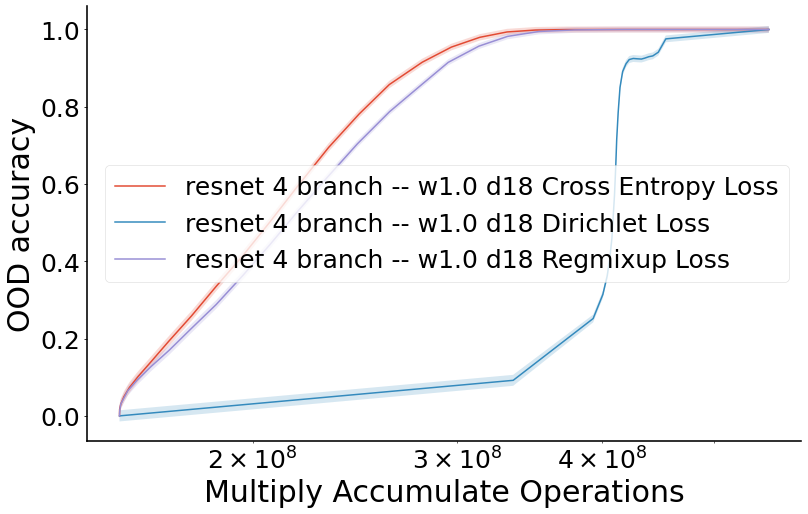

In [10]:
plot_OOD_performance('../trained-models/CIFAR10/resnet_4_branch/w1.0_d18/300-epoch-val-set/analysis/',label_note=' Cross Entropy Loss')
plot_OOD_performance('../trained-models/CIFAR10/resnet_4_branch/w1.0_d18/KL-decrease-lr005-dirichlet-loss/analysis/',label_note=' Dirichlet Loss')
plot_OOD_performance('../trained-models/CIFAR10/resnet_4_branch/w1.0_d18/01-regmixup-regmixup-loss/analysis/',label_note=' Regmixup Loss')

plt.legend()
plt.xscale('log')
plt.ylabel('OOD accuracy')
plt.xlabel('Multiply Accumulate Operations')
plt.show()
